## Global Terrorism Analysis to Predict the terrorist group responsible for a terrorist event

This notebook walks you through
### <a href='#introduction'>Introduction</a>
### <a href="#missing">Dealing with missing data</a>
### <a href='#eda'>Exploratory data analysis</a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xlrd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

<section id='introduction'></section>
## Introduction

> The GTD defines a terrorist attack as the threatened or actual use of illegal force and violence by a non-state actor to attain a political, economic, religious, or social goal through fear, coercion, or intimidation.

### Data
The terrorism data can be downloaded from <a href="http://www.start.umd.edu/gtd/contact/"> here </a>.<br>
Until 2016, __171097__ terrorist events were being recorded. Out of which __6575__ were by __Talibans__. More than __3476__ terrorist groups were created around the globe.

As described in GTD codebook, events in 1993 are approximations. During that year data is lost. So, two files are given. One contains events from 1993 and the other contains events from __1970__ to __2016__ except 1993.

### Problem
The problem is to predict the terrorist group that caused an event.

In [2]:
# Read the files and make eventid as index
events_without_93 = pd.read_excel('./globalterrorismdb_0617dist.xlsx', index_col='eventid')

events_93 = pd.read_excel('./gtd1993_0617dist.xlsx', index_col='eventid')

In [24]:
# Concatenate both the dataframes
events = pd.concat([events_without_93, events_93])
print("Total number of events: {}".format(len(events)))
print("=============================================================")
print()
print("Number of events by terrorist groups:")
print()
print(events['gname'].value_counts())

Total number of events: 171097

Number of events by terrorist groups:

Unknown                                                   78508
Taliban                                                    6575
Shining Path (SL)                                          4585
Islamic State of Iraq and the Levant (ISIL)                4287
Farabundo Marti National Liberation Front (FMLN)           3351
Irish Republican Army (IRA)                                2756
Al-Shabaab                                                 2683
Revolutionary Armed Forces of Colombia (FARC)              2488
New People's Army (NPA)                                    2414
Kurdistan Workers' Party (PKK)                             2196
Boko Haram                                                 2077
Basque Fatherland and Freedom (ETA)                        2031
Communist Party of India - Maoist (CPI-Maoist)             1766
Liberation Tigers of Tamil Eelam (LTTE)                    1613
National Liberation Army of Colom

<section id='missing'></section>
## Dealing with missing data

Out of the vast number of features available, some of those are not so relavant to our problem. And for simplicity features with sentence data are not considered.

All of the data is categorical.

In [25]:
# These are the columns having sentence data or too many missing values which are not so useful
columns_to_drop = ['approxdate', 'resolution', 'summary', 'doubtterr', 'alternative', 'alternative_txt',
                   'location', 'latitude', 'longitude', 'specificity', 'weapdetail', 'individual', 'dbsource']

# related column provides eventid of other events related to this event in text format.
# This is converted to count of the related events
events['related'] = events['related'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)

# These two are dropped later. 
# Though it would be useful but they are having too many values which disturb the harmony of other features
events['provstate'].fillna('Unknown', inplace=True)
events['city'].fillna('Unknown', inplace=True)

# The missing values in these columns are filled with 'unknown' corresponding to a numerical value as per the
# codeboook provided by GTD
events['attacktype2'].fillna(9, inplace=True)
events['attacktype3'].fillna(9, inplace=True)
events['weapsubtype1'].fillna(31, inplace=True)
events['weaptype2'].fillna(13, inplace=True)
events['weapsubtype2'].fillna(31, inplace=True)
events['weaptype3'].fillna(13, inplace=True)
events['weapsubtype3'].fillna(31, inplace=True)
events['weaptype4'].fillna(13, inplace=True)
events['weapsubtype4'].fillna(31, inplace=True)
events['targsubtype1'].fillna(112, inplace=True)
events['corp1'].fillna('Unknown', inplace=True)
events['target1'].fillna('Unknown', inplace=True)
events['natlty1'].fillna('500', inplace=True)
events['targtype2'].fillna(20, inplace=True)
events['targsubtype2'].fillna(112, inplace=True)
events['corp2'].fillna('Unknown', inplace=True)
events['target2'].fillna('Unknown', inplace=True)
events['natlty2'].fillna('500', inplace=True)
events['targtype3'].fillna(20, inplace=True)
events['targsubtype3'].fillna(112, inplace=True)
events['corp3'].fillna('Unknown', inplace=True)
events['target3'].fillna('Unknown', inplace=True)
events['natlty3'].fillna('500', inplace=True)
events['ishostkid'].fillna(-9, inplace=True)
events['ransom'].fillna(-9, inplace=True)

# Drop the columns in columns_to_drop list we created above
events.drop(columns_to_drop, axis=1, inplace=True)

# Drop null columns. This step eliminates all other features as well which we do not need
events.dropna(axis=1, inplace=True)

# Drop null rows to make sure we have no more null values after filling the missing values
events.dropna(inplace=True)

# Finally drop duplicate rows by keeping the first duplicate
events.drop_duplicates(keep='first', inplace=True)

# Also groups with 'Unknown' value is meaningless. So drop those rows
events.drop(events[events['gname']=='Unknown'].index, axis=0, inplace=True)
print('Total number of events after handling missing data: {}'.format(len(events)))

# Now get the value counts and convert it to a dataframe
groups = events['gname'].value_counts().to_dict()
groupsdf = pd.DataFrame.from_dict(groups, orient='index')
groupsdf.reset_index(inplace=True)
groupsdf.columns = ['group', '#events']

print("Number of groups with events more than 2000: {}".format(len(groupsdf[groupsdf['#events'] > 2000])))

Total number of events after handling missing data: 85561
Number of groups with events more than 2000: 9


Drop the groups having less than 2000 events to reduce model complexity i.e. reduces the number of classes.

In [26]:
# Make the groups less than 2000 to 'Other', so that it will be easy to drop
# Using dictionary makes mapping to a dataframe easier
groupsdf.loc[groupsdf['#events'] < 2000, 'group'] = 'Other'
groupsdf = groupsdf.groupby('group').sum()
renamed_groups = groupsdf.to_dict()['#events']
print("After renaming to 'Other'")
print(renamed_groups)

After renaming to 'Other'
{'Taliban': 6316, 'Other': 57184, 'Shining Path (SL)': 3795, 'Revolutionary Armed Forces of Colombia (FARC)': 2372, 'Al-Shabaab': 2642, "Kurdistan Workers' Party (PKK)": 2108, 'Islamic State of Iraq and the Levant (ISIL)': 3757, "New People's Army (NPA)": 2341, 'Irish Republican Army (IRA)': 2544, 'Farabundo Marti National Liberation Front (FMLN)': 2502}


In [27]:
renamed_groups.pop('Other')
print("After popping out 'Other'")
print(renamed_groups)

After popping out 'Other'
{'Taliban': 6316, 'Shining Path (SL)': 3795, 'Revolutionary Armed Forces of Colombia (FARC)': 2372, 'Al-Shabaab': 2642, "Kurdistan Workers' Party (PKK)": 2108, 'Islamic State of Iraq and the Levant (ISIL)': 3757, "New People's Army (NPA)": 2341, 'Irish Republican Army (IRA)': 2544, 'Farabundo Marti National Liberation Front (FMLN)': 2502}


In [28]:
# Map the dictionary to dataframe. If present in our dict keep it else make it NaN
events['gname'] = events['gname'].apply(lambda x: x if x in renamed_groups else np.NaN)
events.dropna(axis=0, inplace=True)
print("Total number of events after dropping geoups less than 2000 events: {}".format(len(events)))

Total number of events after dropping geoups less than 2000 events: 28377


In [29]:
# Drop other text columns and create a new dataframe used for later analysis
text_columns = ['country_txt', 'region_txt', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt']
data = events.drop(text_columns, axis=1)

<section id='eda'></section>
## Exploratory data analysis

The heatmap shows correlation between features. From this we cannot come to a conclusion to keep or drop features as every feature is correlated in someway. But this gives a very good idea of strongly correlated or weakly correlated features.

For example iyear and ransom are strongly negatively correlated with around -0.8 correlation.

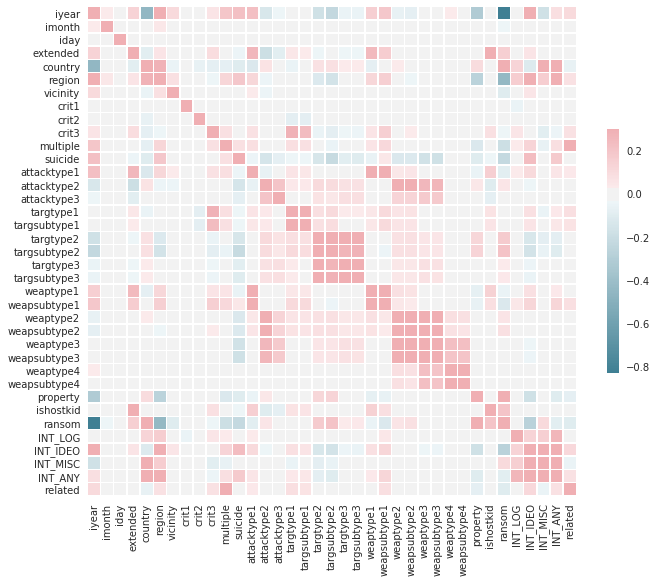

In [12]:
sns.set(style="white")


# Compute the correlation matrix
corr = data.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


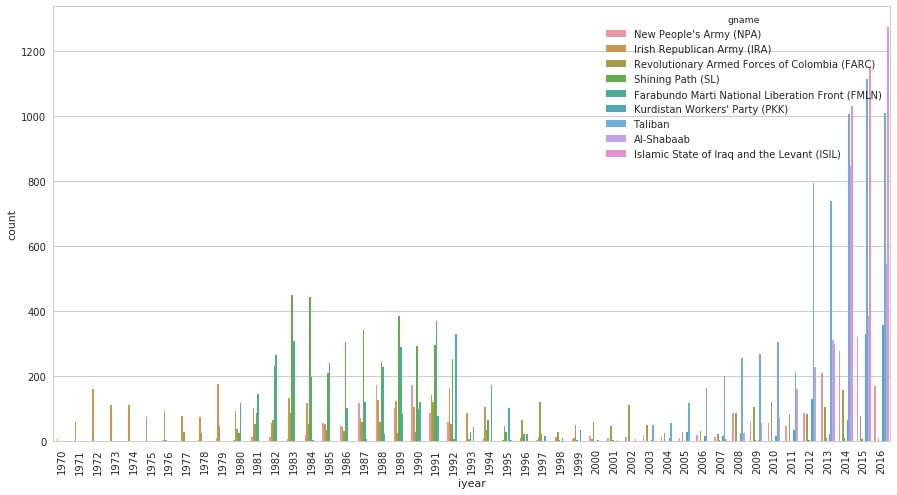

In [13]:
sns.set_style("whitegrid")
sns.countplot(x="iyear", hue="gname", data=data)
plt.xticks(rotation=90)
None

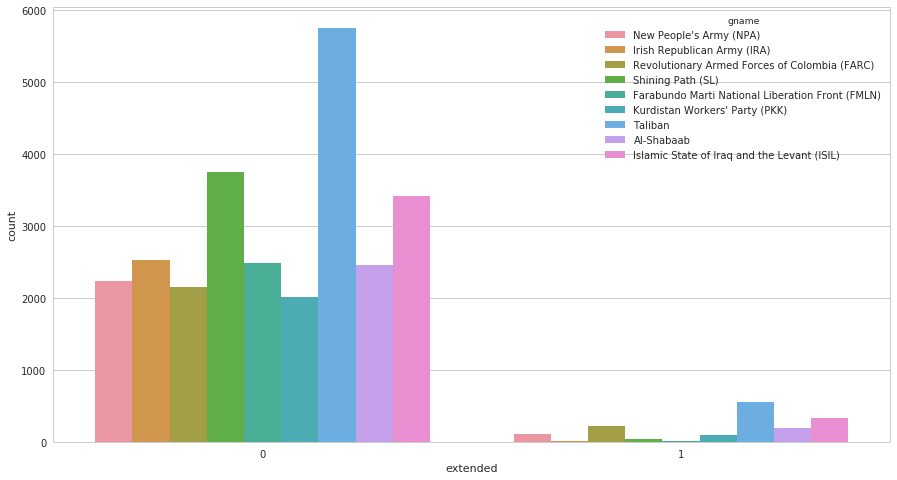

In [14]:
sns.countplot(x="extended", hue="gname", data=data)
None

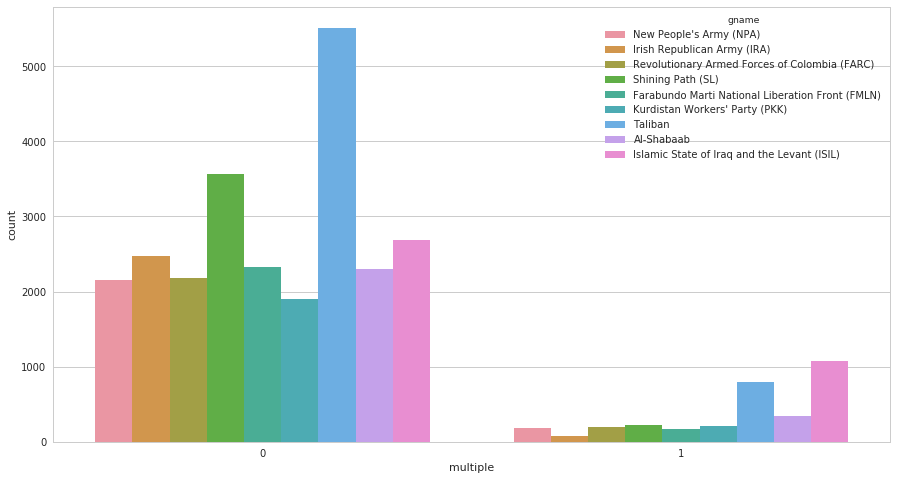

In [15]:
sns.countplot(x="multiple", hue="gname", data=data)
None

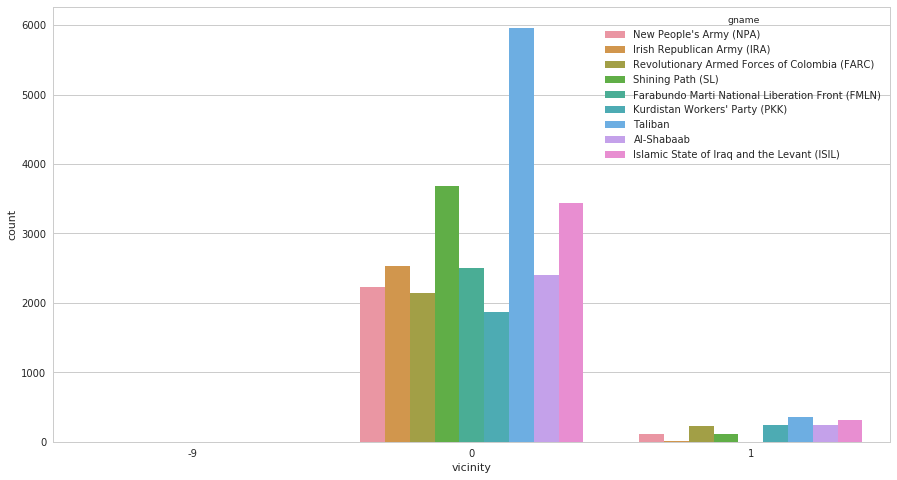

In [16]:
sns.countplot(x="vicinity", hue="gname", data=data)
None

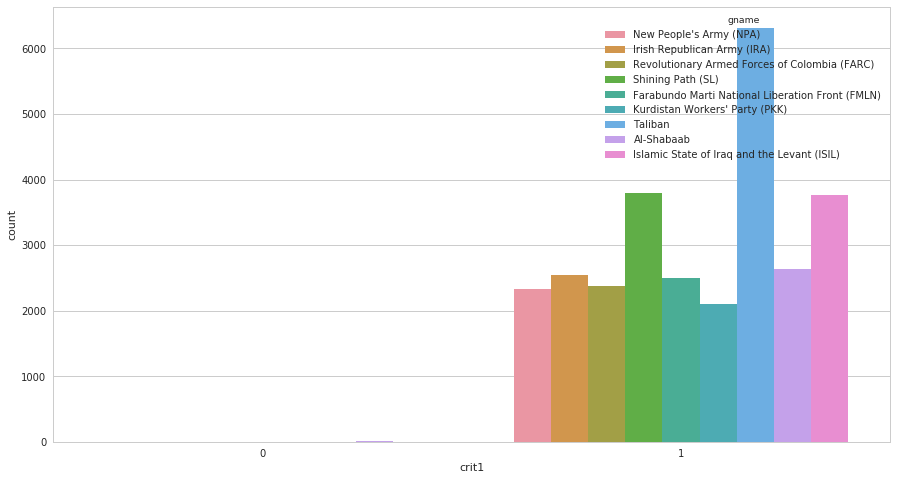

In [17]:
sns.countplot(x="crit1", hue="gname", data=data)
None

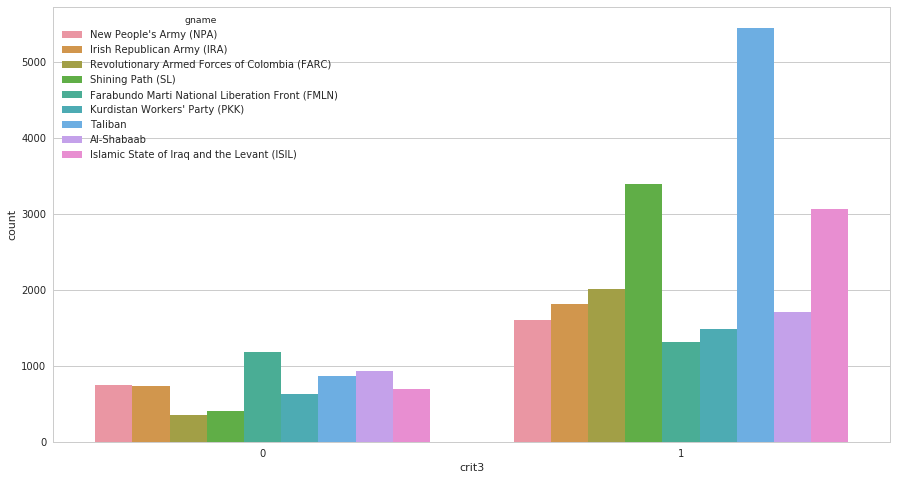

In [18]:
sns.countplot(x="crit3", hue="gname", data=data)
None

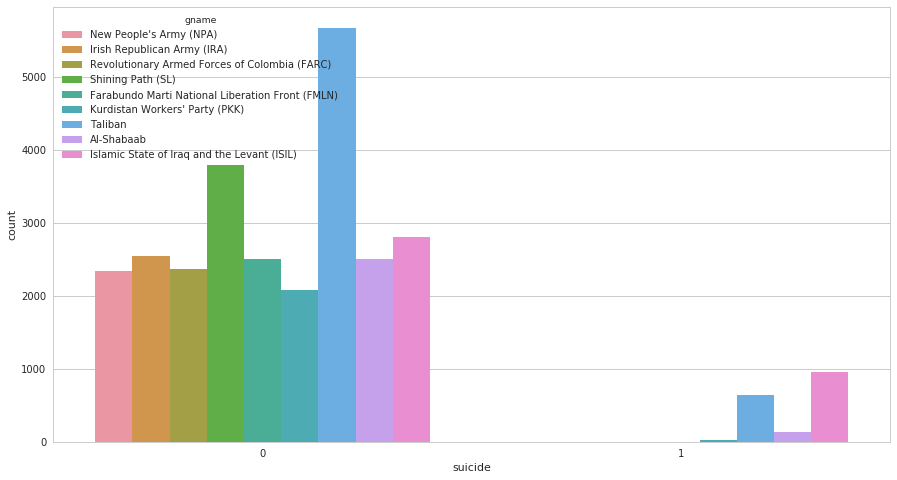

In [19]:
sns.countplot(x="suicide", hue="gname", data=data)
None

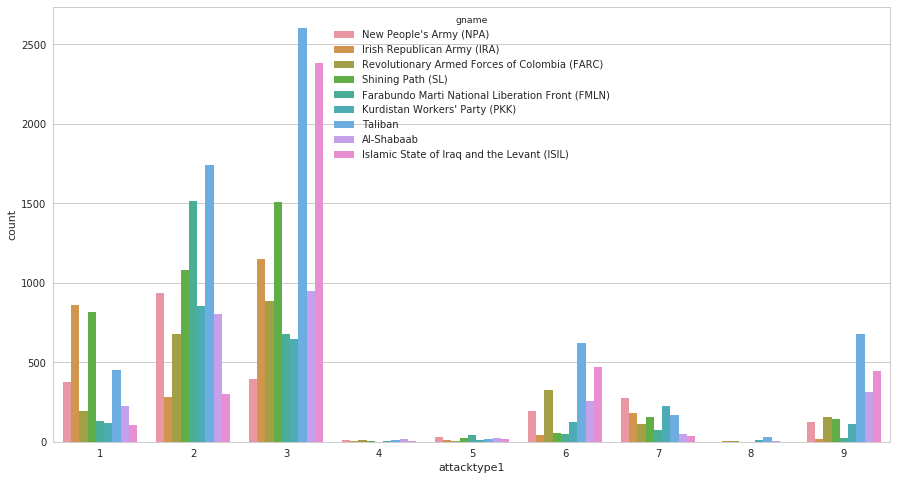

In [20]:
sns.countplot(x="attacktype1", hue="gname", data=data)
None

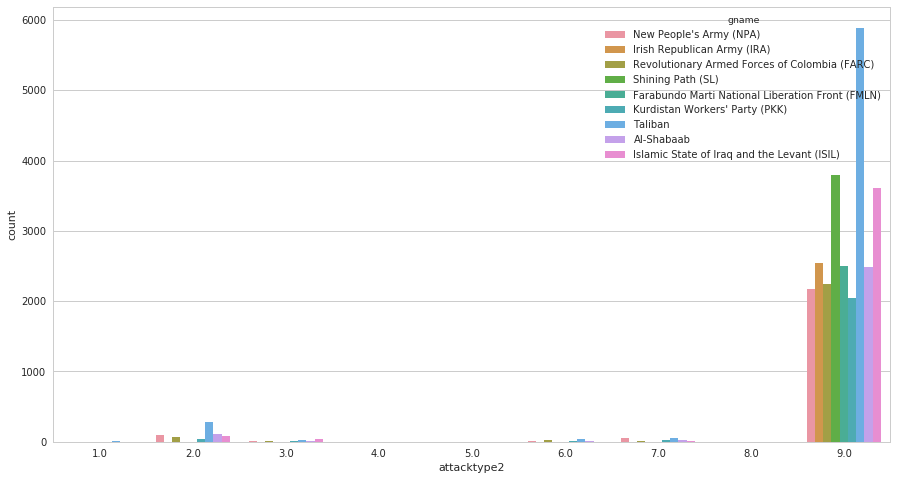

In [21]:
sns.countplot(x="attacktype2", hue="gname", data=data)
None

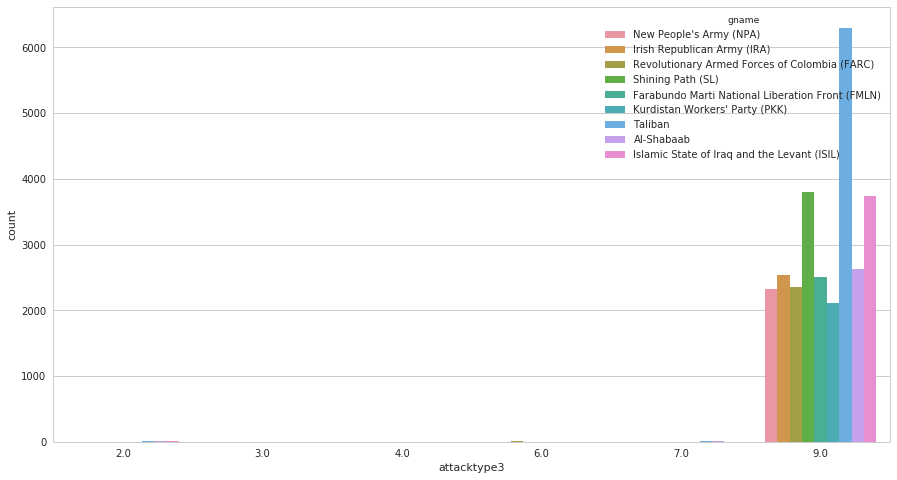

In [22]:
sns.countplot(x="attacktype3", hue="gname", data=data)
None

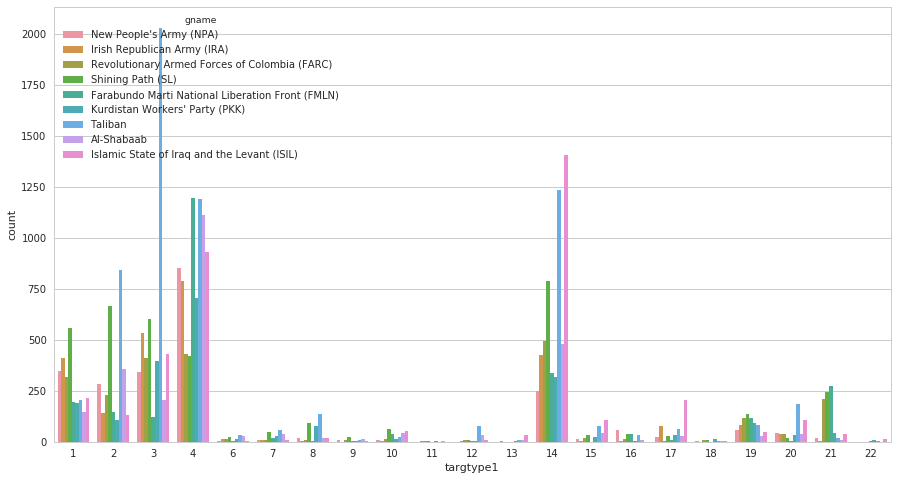

In [23]:
sns.countplot(x="targtype1", hue="gname", data=data)
None

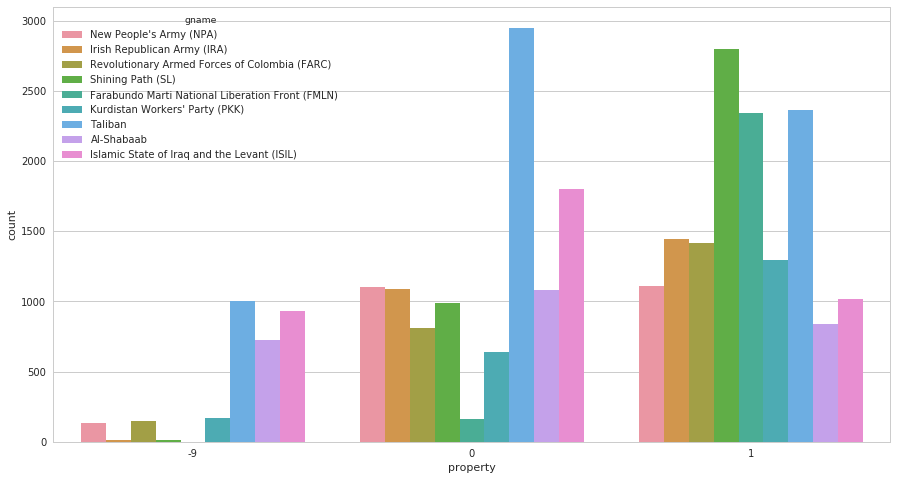

In [26]:
sns.countplot(x="property", hue="gname", data=data)is
None

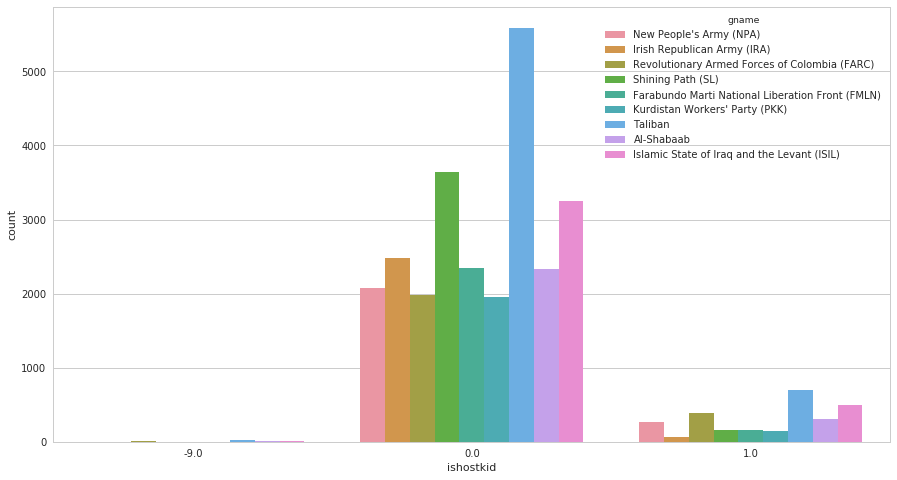

In [27]:
sns.countplot(x="ishostkid", hue="gname", data=data)
None

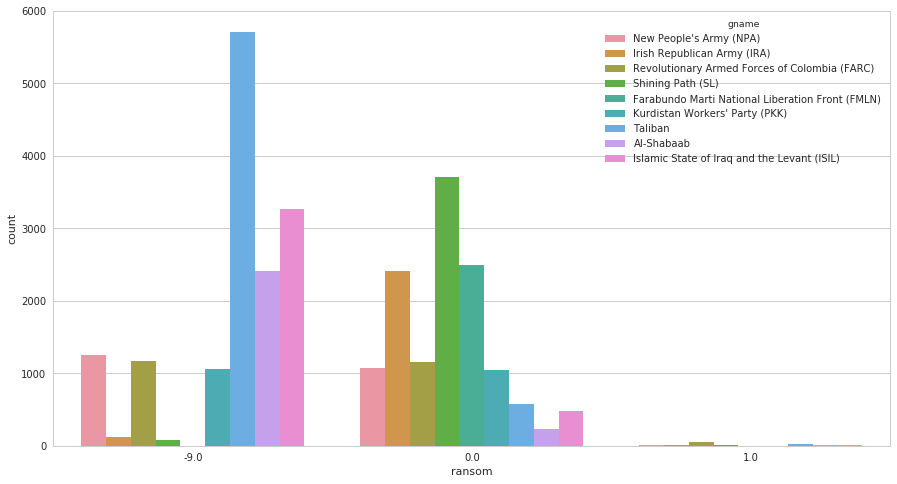

In [28]:
sns.countplot(x="ransom", hue="gname", data=data)
None

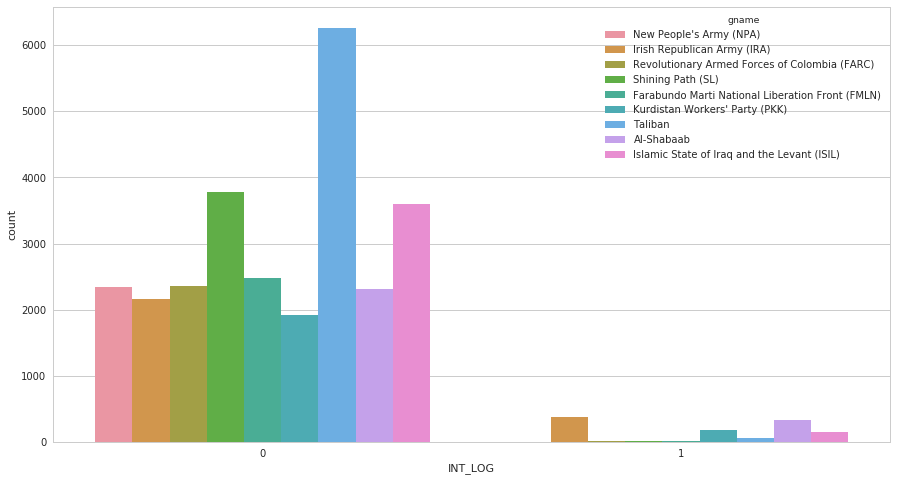

In [29]:
sns.countplot(x="INT_LOG", hue="gname", data=data)
None

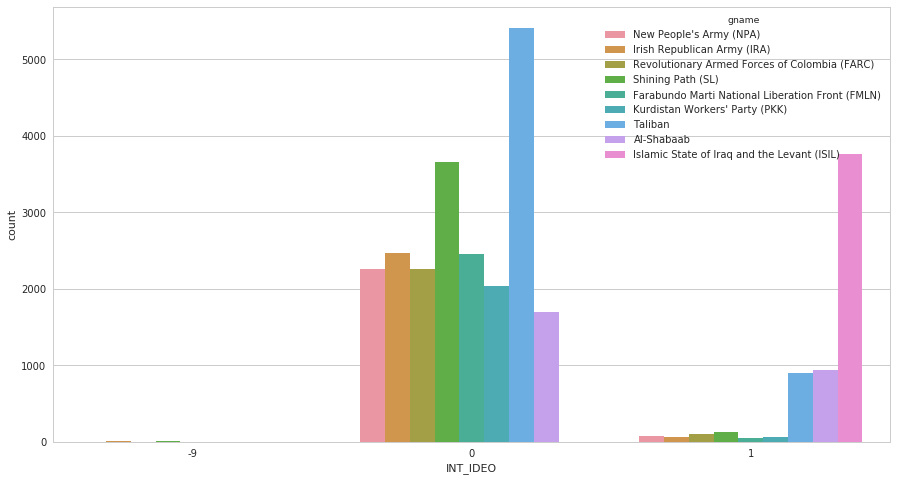

In [30]:
sns.countplot(x="INT_IDEO", hue="gname", data=data)
None

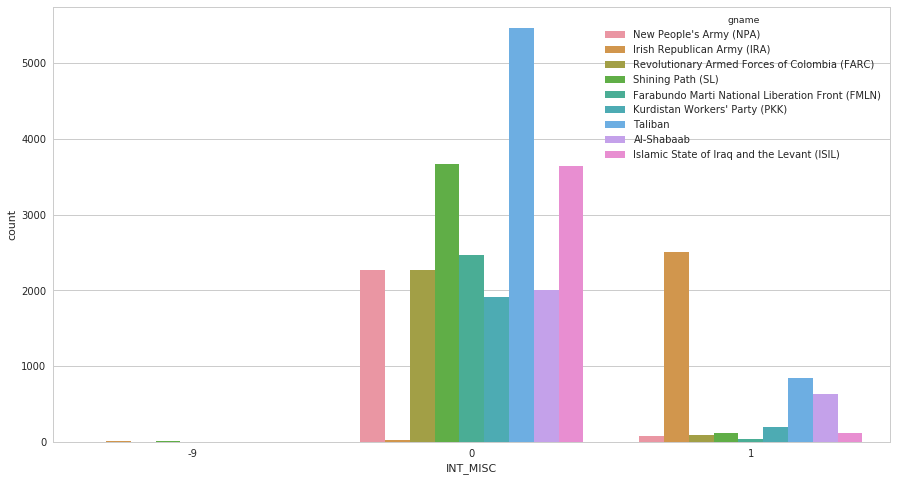

In [31]:
sns.countplot(x="INT_MISC", hue="gname", data=data)
None

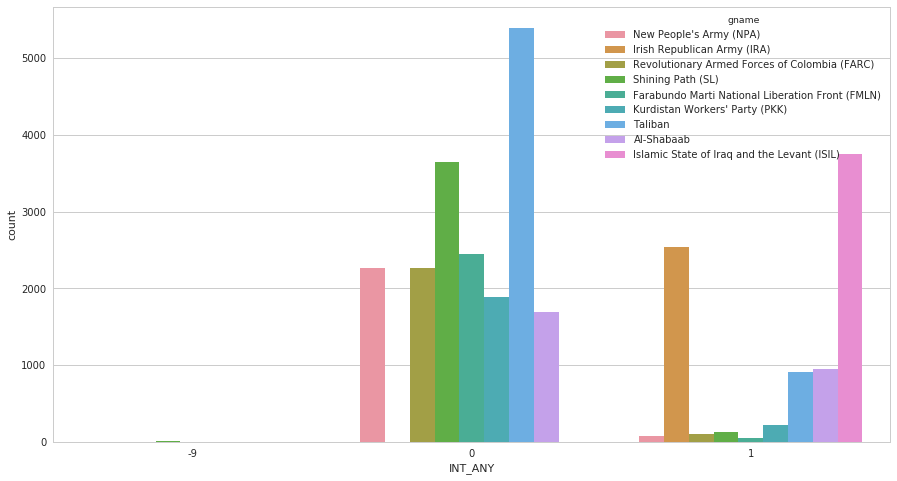

In [32]:
sns.countplot(x="INT_ANY", hue="gname", data=data)
None

In [48]:
features_drop = ['crit1', 'crit2', 'attacktype3', 'corp1', 'corp2', 'corp3', 'target1', 'target2', 
                 'target3', 'ransom', 'INT_MISC', 'INT_ANY', 'city', 'provstate']
data.drop(features_drop, axis=1, inplace=True)

(35,
 Index(['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'vicinity',
        'crit3', 'multiple', 'suicide', 'attacktype1', 'attacktype2',
        'targtype1', 'targsubtype1', 'natlty1', 'targtype2', 'targsubtype2',
        'natlty2', 'targtype3', 'targsubtype3', 'natlty3', 'gname', 'weaptype1',
        'weapsubtype1', 'weaptype2', 'weapsubtype2', 'weaptype3',
        'weapsubtype3', 'weaptype4', 'weapsubtype4', 'property', 'ishostkid',
        'INT_LOG', 'INT_IDEO', 'related'],
       dtype='object'))

In [49]:
data['natlty1'] = data['natlty1'].astype(int)
data['natlty2'] = data['natlty2'].astype(int)
data['natlty3'] = data['natlty3'].astype(int)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28377 entries, 197001310001 to 199312300003
Data columns (total 35 columns):
iyear           28377 non-null int64
imonth          28377 non-null int64
iday            28377 non-null int64
extended        28377 non-null int64
country         28377 non-null int64
region          28377 non-null int64
vicinity        28377 non-null int64
crit3           28377 non-null int64
multiple        28377 non-null int64
suicide         28377 non-null int64
attacktype1     28377 non-null int64
attacktype2     28377 non-null float64
targtype1       28377 non-null int64
targsubtype1    28377 non-null float64
natlty1         28377 non-null int64
targtype2       28377 non-null float64
targsubtype2    28377 non-null float64
natlty2         28377 non-null int64
targtype3       28377 non-null float64
targsubtype3    28377 non-null float64
natlty3         28377 non-null int64
gname           28377 non-null object
weaptype1       28377 non-null int64
weapsubty

In [52]:
x = data.drop(['gname'], axis=1)
y = data['gname']

In [53]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

/home/naveen/Desktop/general/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [57]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
accuracy_score(y_test, preds)

0.95243128964059198

In [58]:
confusion_matrix(y_test, preds)

array([[264,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 225,   0,   0,   0,   0,  20,   5,   0],
       [  0,   0, 245,   0,   8,   1,   0,   0,   0],
       [  0,   0,   3, 365,   4,   4,   0,   0,   0],
       [  0,   0,   0,   1, 207,   1,   0,   0,   2],
       [  0,   0,   0,   3,   4, 227,   0,   0,   0],
       [  0,  66,   0,   0,   0,   1, 168,   2,   0],
       [  0,   1,   0,   0,   1,   0,   1, 377,   0],
       [  0,   1,   2,   0,   1,   3,   0,   0, 625]])